# Introdução

Essa base inclui um conjunto de 80.899 registros distribuídos em 19 variáveis, com dados cobrindo diferentes etapas do ciclo orçamentário, desde a aprovação das emendas até os pagamentos efetivos. As principais variáveis incluem:

**Ano e Tipo de Emenda**: Informações sobre o ano de aprovação e a categoria da emenda (individual, de bancada, de comissão, etc.).

**Autor da Emenda**: Nome e código dos parlamentares responsáveis.

**Localidade do Gasto**: Dados geográficos, como município e unidade federativa beneficiados.

**Função e Subfunção**: Classificações orçamentárias que detalham a finalidade dos recursos (ex.: saúde, educação, assistência social).

**Valores Financeiros**: Indicadores como valores empenhados, liquidados, pagos e restos a pagar.

---

# Limpeza e Tratamento dos Dados

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Carregando os dados parlamentares
file_path = '/content/br_cgu_emendas_parlamentares_microdados.csv'
df = pd.read_csv(file_path)

<ipython-input-4-09d8fcf1cf7c>:3: DtypeWarning: Columns (4,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [21]:
# Vamos exibir as principais infos do dataset, como tipo de dados por coluna e quantidade de valores nulos
print("Informações iniciais do dataset:")
df.info()

Informações iniciais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80899 entries, 0 to 80898
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ano_emenda                   80899 non-null  int64  
 1   codigo_emenda                80899 non-null  object 
 2   numero_emenda                80899 non-null  object 
 3   tipo_emenda                  80899 non-null  object 
 4   codigo_autor_emenda          80899 non-null  object 
 5   nome_autor_emenda            80899 non-null  object 
 6   localidade_gasto             80899 non-null  object 
 7   id_municipio_gasto           35937 non-null  float64
 8   sigla_uf_gasto               80899 non-null  object 
 9   codigo_funcao                80899 non-null  int64  
 10  nome_funcao                  80899 non-null  object 
 11  codigo_subfuncao             80899 non-null  int64  
 12  nome_subfuncao               80899 non-nu

### 2.1. Tratamento de valores ausentes

Justificativa:
 - Para colunas numéricas, substituímos valores ausentes por zero ou média, dependendo do significado.
 - Para colunas categóricas, preenchemos com 'Desconhecido' ou removemos se não forem relevantes.

In [6]:
# Substituindo os valores ausentes nas colunas financeiras por 0
finance_columns = [
    'valor_empenhado', 'valor_liquidado', 'valor_pago',
    'valor_resto_pagar_inscrito', 'valor_resto_pagar_cancelado', 'valor_resto_pagar_pagos'
]
df[finance_columns] = df[finance_columns].fillna(0)

In [7]:
# Substituindo valores ausentes em colunas categóricas por "Desconhecido"
# Isso uniformiza a falta de referencia pra uma informação na base toda
categorical_columns = ['localidade_gasto', 'sigla_uf_gasto']
df[categorical_columns] = df[categorical_columns].fillna('Desconhecido')

In [22]:
# Somando os valores nulos restantes
# A coluna id_municipio_gato contem um Pticularidade q n permite sua exclusão ou substituição
print("Valores ausentes após preenchimento:")
print(df.isnull().sum())

Valores ausentes após preenchimento:
ano_emenda                         0
codigo_emenda                      0
numero_emenda                      0
tipo_emenda                        0
codigo_autor_emenda                0
nome_autor_emenda                  0
localidade_gasto                   0
id_municipio_gasto             44962
sigla_uf_gasto                     0
codigo_funcao                      0
nome_funcao                        0
codigo_subfuncao                   0
nome_subfuncao                     0
valor_empenhado                    0
valor_liquidado                    0
valor_pago                         0
valor_resto_pagar_inscrito         0
valor_resto_pagar_cancelado        0
valor_resto_pagar_pagos            0
dtype: int64


id_municipio_gasto parece representar identificadores específicos de municípios, e os valores ausentes podem indicar que a emenda não foi direcionada a um município específico (como em casos de abrangência nacional).
Com mais de 50% de valores ausentes, tratar diretamente essa coluna com preenchimento genérico poderia causar erros interpretativos.

O ideal seria substituir valores ausentes por "Não especificado" ou equivalente, mas isso pode gerar confusão se não houver correspondência exata.Devido a isso, deixamos esse valores ausentes e tratamos a coluna em análises subsequentes, considerando a ausência como uma característica relevante.

### 2.2. Conversão de tipos de dados inconsistentes

Justificativa:
- Dados inconsistentes (tipos mistos) podem causar erros em análises ou gráficos.
- Convertê-los para o tipo correto garante melhor desempenho.

In [9]:
# Convertendo colunas numéricas com tipos mistos
mixed_columns = ['codigo_funcao', 'codigo_subfuncao']
for col in mixed_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

In [10]:
# Substituindo valores não especificados ("Sem informação") por "Desconhecido"
df.replace("Sem informação", "Desconhecido", inplace=True)

### 2.3. Remoção de duplicatas

Justificativa:
- Remover registros duplicados evita redundância.
- É útil para análises mais precisas e evita sobrecontagem.

In [23]:
# Removendo duplicatas, mantendo o primeiro registro
# Só se certificando de valores válidos
print(f"Registros antes da remoção de duplicatas: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Registros após a remoção de duplicatas: {len(df)}")

Registros antes da remoção de duplicatas: 80899
Registros após a remoção de duplicatas: 80899


### 2.4. Normalização e limpeza de textos

 Justificativa:
 - Padronizar textos melhora a consistência dos dados e facilita análises categóricas.

In [12]:
# Removendo espaços extras e padronizando texto em colunas categóricas
text_columns = ['nome_autor_emenda', 'localidade_gasto', 'nome_funcao', 'nome_subfuncao']
df[text_columns] = df[text_columns].apply(lambda x: x.str.strip().str.upper())

In [13]:
# Verificando amostra dos dados após limpeza
print("Amostra dos dados limpos:")
df.head()

Amostra dos dados limpos:


,ano_emenda,codigo_emenda,numero_emenda,tipo_emenda,codigo_autor_emenda,nome_autor_emenda,localidade_gasto,id_municipio_gasto,sigla_uf_gasto,codigo_funcao,nome_funcao,codigo_subfuncao,nome_subfuncao,valor_empenhado,valor_liquidado,valor_pago,valor_resto_pagar_inscrito,valor_resto_pagar_cancelado,valor_resto_pagar_pagos
0,2017,Desconhecido,Desconhecido,Emenda de Comissão,-99,RELATOR GERAL,NACIONAL,NaN,Desconhecido,3,ESSENCIAL À JUSTIÇA,92,REPRESENTAÇÃO JUDICIAL E EXTRAJUDICIAL,6.616576e+06,1.339455e+06,1.318481e+06,0.0,2385233.40,2912861.62
1,2016,Desconhecido,Desconhecido,Emenda de Comissão,-99,RELATOR GERAL,NACIONAL,NaN,Desconhecido,26,TRANSPORTE,121,PLANEJAMENTO E ORÇAMENTO,5.928024e+06,1.044254e+06,1.044254e+06,0.0,3306819.34,1576951.50
2,2017,Desconhecido,Desconhecido,Emenda de Comissão,-99,RELATOR GERAL,NACIONAL,NaN,Desconhecido,4,ADMINISTRAÇÃO,121,PLANEJAMENTO E ORÇAMENTO,3.964921e+08,2.698707e+08,2.692729e+08,0.0,29806068.67,97413142.28
3,2018,Desconhecido,Desconhecido,Emenda de Comissão,-99,RELATOR GERAL,PETROLINA - PE,2611101.0,PE,10,SAÚDE,122,ADMINISTRAÇÃO GERAL,2.000000e+06,0.000000e+00,0.000000e+00,0.0,0.00,2000000.00
4,2017,Desconhecido,Desconhecido,Emenda de Comissão,-99,RELATOR GERAL,NACIONAL,NaN,Desconhecido,26,TRANSPORTE,122,ADMINISTRAÇÃO GERAL,8.850000e+05,0.000000e+00,0.000000e+00,0.0,1050.93,883949.07


### Finalizando...

In [14]:
# Salvar o dataset limpo
cleaned_file_path = '/content/cleaned_emendas_parlamentares.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"Dados limpos salvos em: {cleaned_file_path}")

Dados limpos salvos em: /content/cleaned_emendas_parlamentares.csv


---

# EDA (Exploratory Data Analisys)

In [24]:
# Resumo estatístico das colunas numéricas
numeric_summary = df.describe()

# Distribuição das colunas categóricas mais relevantes
categorical_columns = ['tipo_emenda', 'sigla_uf_gasto', 'nome_funcao', 'nome_subfuncao']
categorical_summary = {col: df[col].value_counts().head(10) for col in categorical_columns}

# Exibir resumos
numeric_summary, categorical_summary

(         ano_emenda  id_municipio_gasto  codigo_funcao  codigo_subfuncao  \
 count  80899.000000        3.593700e+04   80899.000000      80899.000000   
 mean    2018.666745        3.126222e+06      13.576806        397.227209   
 std        3.085527        1.010734e+06       6.136014        205.416475   
 min     2014.000000        1.100015e+06       0.000000          0.000000   
 25%     2016.000000        2.411205e+06      10.000000        301.000000   
 50%     2019.000000        3.157708e+06      10.000000        302.000000   
 75%     2021.000000        3.550308e+06      15.000000        451.000000   
 max     2024.000000        5.300108e+06      28.000000        847.000000   
 
        valor_empenhado  valor_liquidado    valor_pago  \
 count     8.089900e+04     8.089900e+04  8.089900e+04   
 mean      3.066915e+06     1.617691e+06  1.595314e+06   
 std       4.280206e+07     3.373935e+07  3.369831e+07   
 min       0.000000e+00     0.000000e+00  0.000000e+00   
 25%       2.50

In [16]:
# Distribuições das Colunas Numéricas
numeric_columns = [
    'valor_empenhado', 'valor_liquidado', 'valor_pago',
    'valor_resto_pagar_inscrito', 'valor_resto_pagar_cancelado', 'valor_resto_pagar_pagos'
]

# As colunas categoricas já foram definidas em categorical_columns

### 1. Categorias

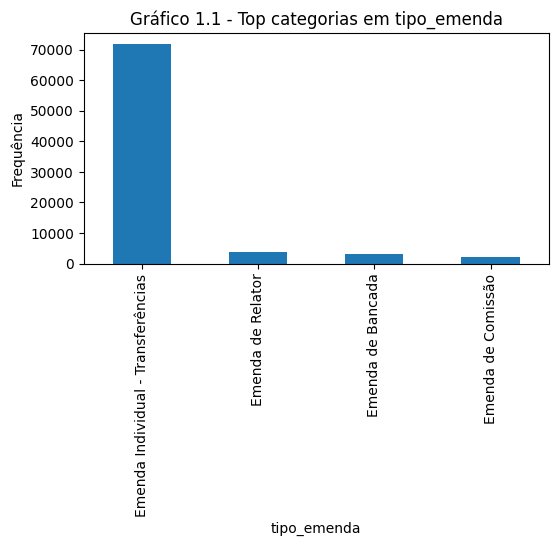

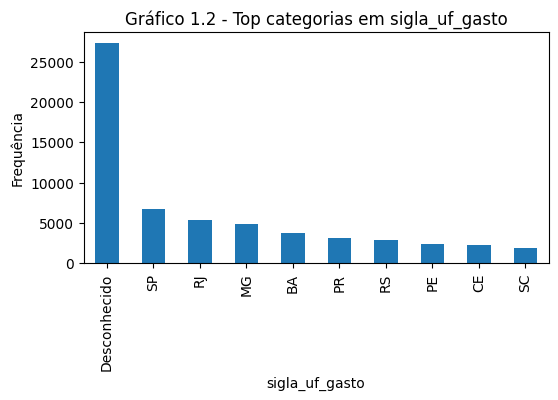

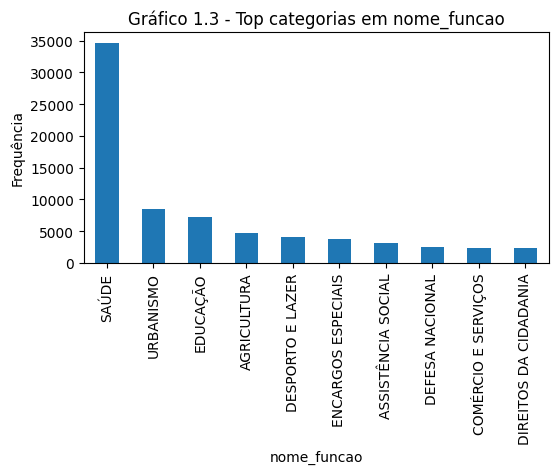

In [17]:
counter = 1

# Frequências das Categorias Principais
for column in categorical_columns[:-1]:

    plt.figure(figsize=(6, 3))
    df[column].value_counts().head(10).plot(kind='bar')
    plt.title(f"Gráfico 1.{counter} - Top categorias em {column}")
    counter = counter + 1
    plt.xlabel(column)
    plt.ylabel("Frequência")
    plt.show()

### 2 . Relação

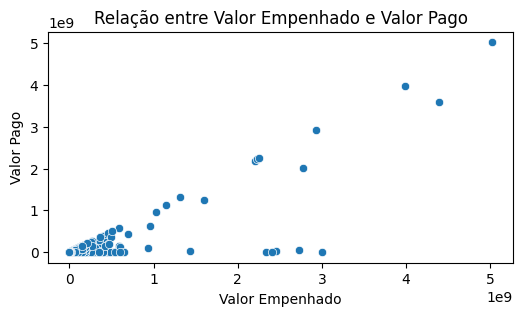

In [18]:
# Relação entre valores empenhados e pagos
plt.figure(figsize=(6, 3))
sns.scatterplot(x='valor_empenhado', y='valor_pago', data=df)
plt.title("Relação entre Valor Empenhado e Valor Pago")
plt.xlabel("Valor Empenhado")
plt.ylabel("Valor Pago")
plt.show()

### 3 . Correlação

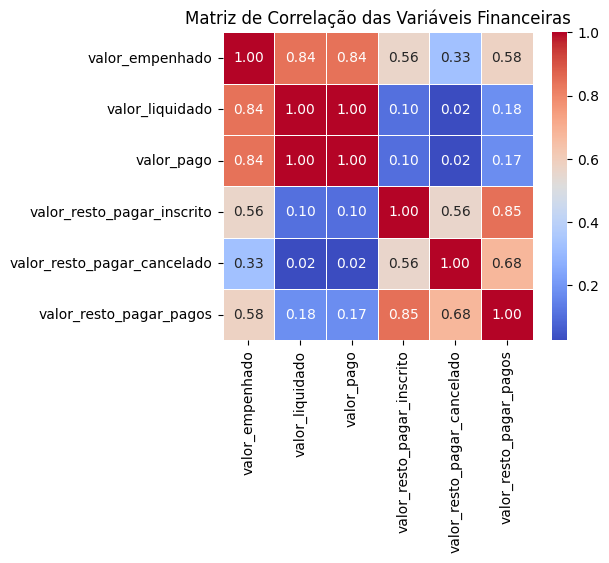

In [19]:
# Correlação entre Variáveis Financeiras
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis Financeiras")
plt.show()

### Frequências das Categorias:

tipo_emenda: Predominância das "Emendas Individuais - Transferências".
sigla_uf_gasto: Estados como São Paulo, Rio de Janeiro e Minas Gerais concentram a maioria dos registros.
nome_funcao: Funções como Saúde e Urbanismo lideram os gastos.

### Relação entre Valores Empenhados e Pagos:

A análise de dispersão mostra que muitos valores empenhados não são pagos ou são pagos de maneira parcial.

### Correlação entre Variáveis Financeiras:

Existe uma correlação forte e positiva entre valor_empenhado e valor_liquidado, assim como entre valor_liquidado e valor_pago.
Outras variáveis apresentam correlações mais fracas, indicando menor dependência.

---

# Breve análise dos Dados

### Distribuição dos Valores Financeiros:

Os valores financeiros (valor_empenhado, valor_pago, etc.) apresentam distribuições extremamente enviesadas, com a maioria concentrada em valores baixos ou nulos.
Há outliers significativos, indicando projetos ou emendas com alocações excepcionalmente altas.

### Tipos de Emendas:

O tipo predominante é a "Emenda Individual - Transferências", que representa a maior parte dos registros. Isso sugere uma predominância de emendas voltadas para iniciativas individuais em relação a bancadas ou comissões.

### Foco Geográfico:

Os estados de São Paulo, Rio de Janeiro e Minas Gerais concentram a maior parte dos registros, indicando maior alocação de recursos ou número de projetos nessas localidades.

### Áreas de Aplicação:

A função "Saúde" domina as alocações, seguida por "Urbanismo" e "Educação". Isso reflete as prioridades em setores essenciais.
Nas subfunções, "Atenção Básica" e "Assistência Hospitalar e Ambulatorial" são as mais destacadas, reforçando o foco em saúde pública.